**! НЕ ХВАТАЕТ CPU
НЕОБХОДИМО НАЙТИ БАЛАНС В ДАННЫХ ! НЕОХОДИМО НАСТРОИТЬ ОКРУЖЕНИЕ, НИХУЯ НЕРАБОТАЕТ ЛОКАЛЬНО**
# Прогнозирование временных рядов с помощью рекуррентных нейронных сетей

In [ ]:
# Импорты
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
# Цвета граффиков
mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.facecolor'] = '#11121B'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#222433'

In [ ]:
# Импорт датасета и его обрезка.
df = pd.read_csv('./df.csv')[3000000:]

# Фильтрация NaN значений (обязательна)
df = df.dropna()

# Преобразование дат
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.head()

Период записи наблюдения составляет 1 минут, можно убедиться по вышеприведённой таблице. Таким образом, в течение одного часа у вас будет 60 наблюдений. В свою очередь за сутки накапливается 1 440 (60x24) наблюдения.

Допустим, мы хотим cпрогнозировать курс, который будет через 6 часов в будущем. Этот прогноз мы делаем на основе имеющихся у нас данных за определённый период: например, мы решили использовать 5 дней наблюдений. Следовательно, для обучения модели вы должны создать временной интервал, содержащий последние 7200 (5x1440) наблюдений (в виду того, что возможны разные конфигурации, данный набор данных является хорошей основой для экспериментов).

Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. Аргумент history_size — это размер последнего временного интервала, target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

В обеих частях руководства первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). В этом случае объём обучающих данных составляет примерно 208 дней.

In [ ]:
TRAIN_SPLIT = 100000

Для обеспечения воспроизводимости результатов устанавливается функция seed.

In [ ]:
tf.random.set_seed(13)

# Часть 1. Прогнозирование на основе одномерного временного ряда
В первой части мы будем обучать модель, используя только один признак – цену; обученная модель будет использоваться для прогнозирования будущих значений цены.

Для начала извлечем только цену из набора данных.

In [ ]:
uni_data = df['Weighted_Price']
uni_data.index = df['Timestamp']
uni_data.head()

Визуализируем данные

In [ ]:
uni_data.plot(subplots=True, color='white')

In [ ]:
uni_data = uni_data.values

Перед обучением искусственной нейронной сети (далее – ИНС) важным шагом является масштабирование данных. Одним из распространённых способов выполнения масштабирования является стандартизация (standardization), выполняемая путём вычитания среднего значения и деления на стандартное отклонение для каждого признака. Вы также можете использовать метод tf.keras.utils.normalize, который масштабирует значения в диапазон [0,1].

***Примечание:*** *стандартизация должна выполняться только c использованием обучающих данных.*

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data

Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться последние 20 зарегистрированных наблюдений за ценой, и модель необходимо обучить прогнозировать цену на следующем шаге по времени.

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Результаты применения функции univariate_data.

In [ ]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target price to predict')
print (y_train_uni[0])

Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. Передаваемая в ИНС информация выделена синим цветом, красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Базовое решение (без привлечения машинного обучения)

Прежде чем приступить к обучению модели, установим простое базовое решение (baseline). Оно заключается в следующем: для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних 20 наблюдений.

In [ ]:
def baseline(history):
  return np.mean(history)

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Посмотрим, сможем ли мы превзойти результат «усреднения», использую рекуррентную нейронную сеть.

# Рекуррентная нейронная сеть

Рекуррентная нейронная сеть (РНС) — это тип ИНС, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов. Более подробную информацию о РНС можно найти в следующем [руководстве](https://www.tensorflow.org/tutorials/text/text_generation?hl=ru). В данном руководстве будет использоваться специализированный слой РНС, который называется **«Долгая краткосрочная память»** (англ. Long Short-Term Memory, LSTM).

Далее с помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.

*Подробнее про методы shuffle, batch и cache на странице tensorflow*

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Следующая визуализация должна помочь понять, как выглядят данные после пакетной обработки.
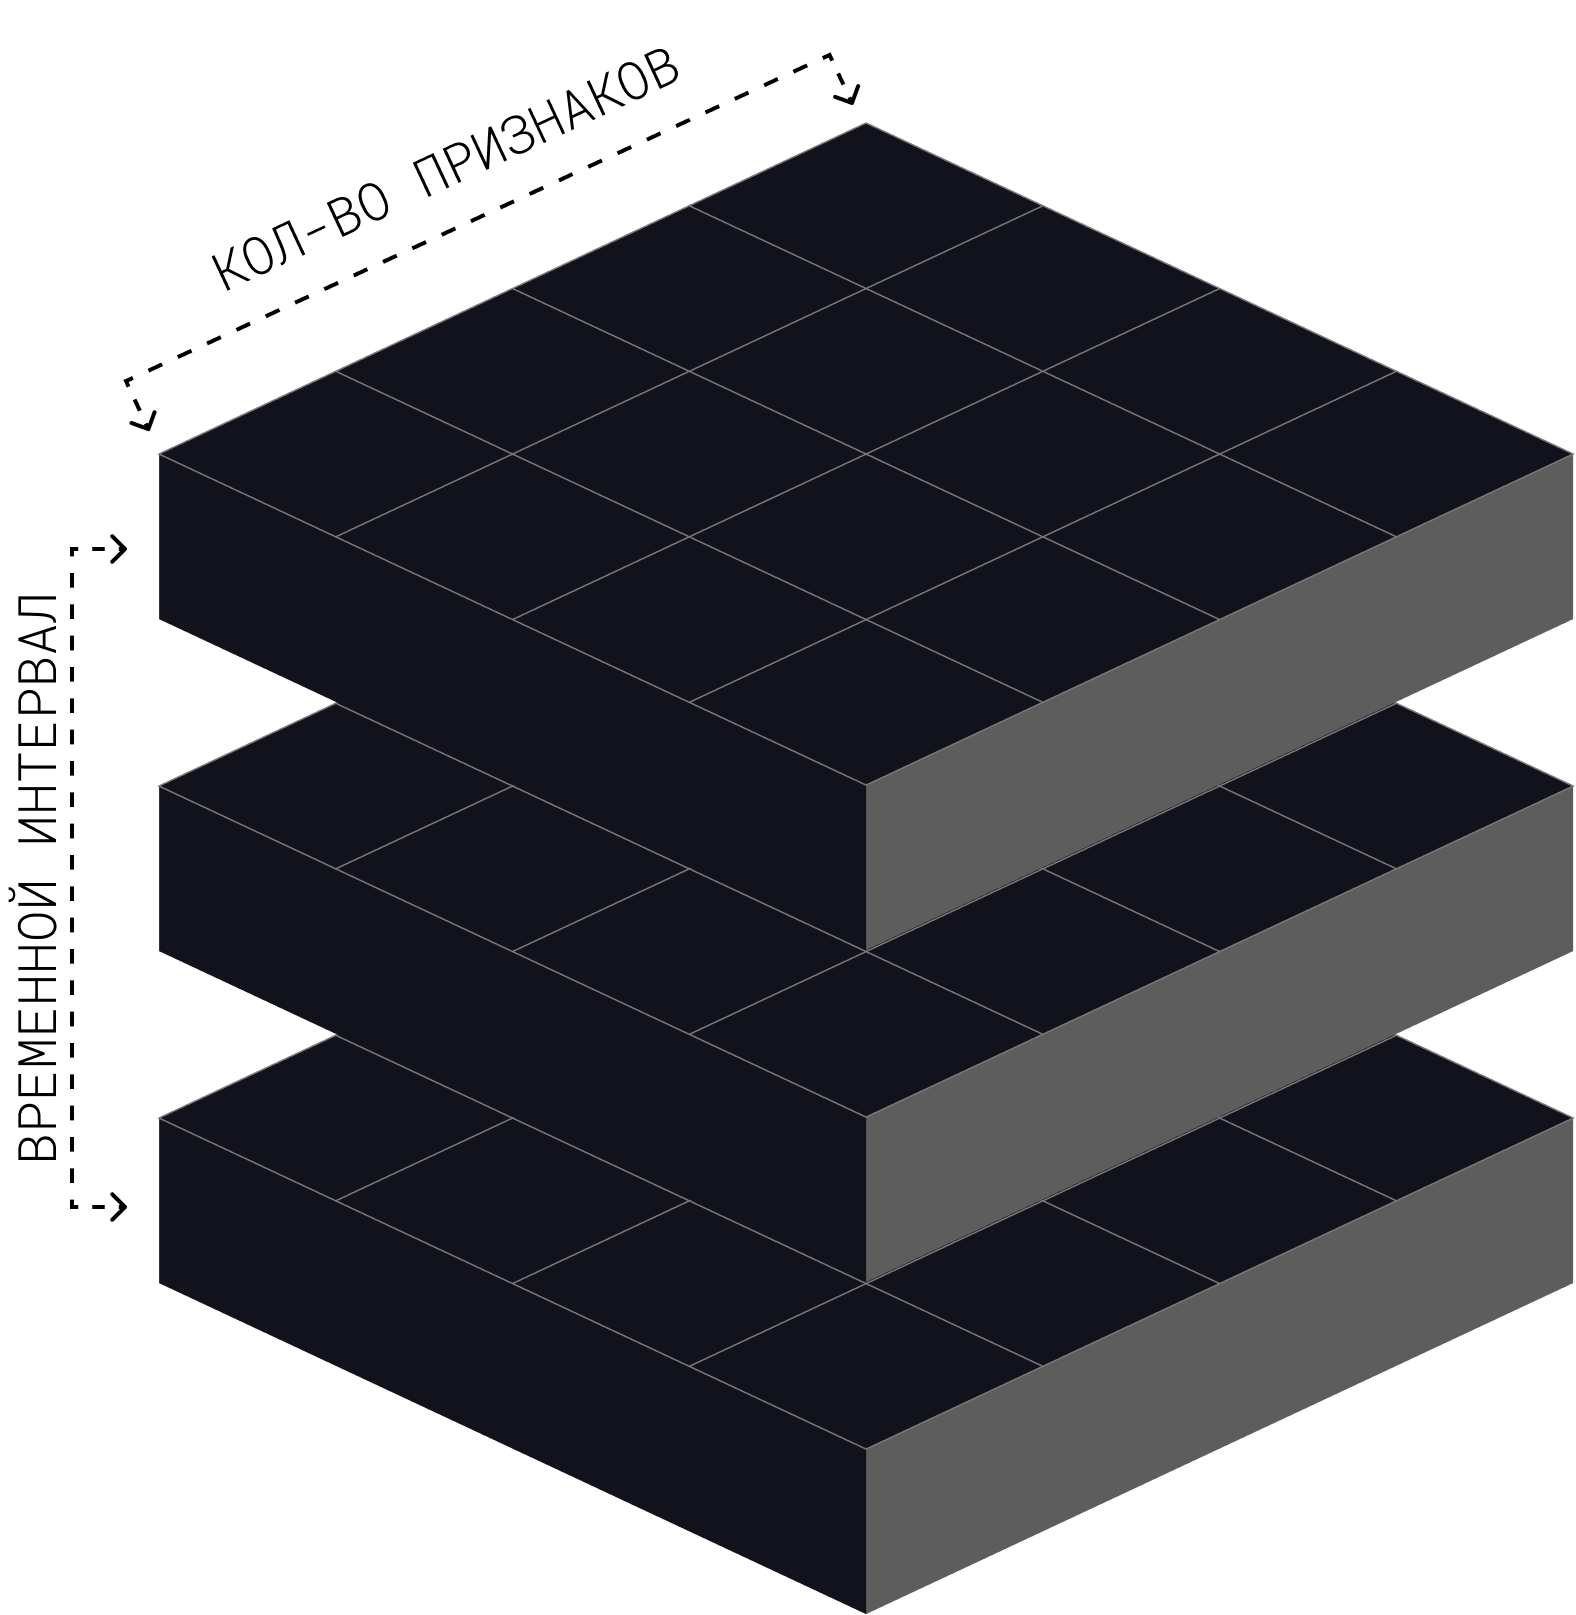
Видно, что LSTM требует определённой формы ввода данных, которые ему предоставляются.

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Проверим выход модели.

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

Далее займёмся обучением модели. Из-за большого размера набора данных и в целях экономии времени каждая эпоха будет проходить только 200 шагов (steps_per_epoch=200) вместо полных данных обучения, как это обычно делается.

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

### Прогнозирование с использованием простой модели LSTM

После выполнения подготовки простой LSTM-модели, выполним несколько прогнозов.

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

Нууу получше... но не то что нужно

# Часть 2: Прогнозирование на основе многомерного временного ряда
Искользуем несколько показателей.
Чтобы использовать больше признаков, их названия нужно добавить в список feature_considered.

In [ ]:
features_considered = ['Open', 'Close', 'High', 'Low']

In [ ]:
features = df[features_considered]
features.index = df['Timestamp']
features.head()

Посмотрим, как эти показатели изменяются во времени.

In [ ]:
features.plot(subplots=True, color='white')

Как и ранее, первым шагом будет выполнение стандартизации набора данных с вычислением среднего значения и стандартного отклонения обучающих данных.

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

## Точечное прогнозирование
В данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.
Приведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения на основе заданного размера шага.

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

В данном руководстве ИНС оперирует данными за последние пять (5) дней, то есть 7200 наблюдениями (60х24х5). Допустим, что отбор данных проводится не каждую минуту, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (1720/60). Для модели, выполняющей точечное прогнозирование, целью является значение цены через 12 часов в будущем. В этом случае целевой вектор будет составлять цена после 720 (12х60) наблюдений.

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Проверим временной интервал.

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки.

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

## Выполнение точечного прогноза

Теперь, когда модель обучена, выполним несколько пробных прогнозов. На вход модели подаётся история наблюдений 3-х признаков за последние пять дней, отобранных каждый час (временной интервал = 120). Так как наша цель заключается в прогнозе только цены, то синим цветом на графике отображены прошлые значения цены (история). Прогноз выполнен на полдня в будущее (отсюда и разрыв между историей и спрогнозированным значением).

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

## Интервальное прогнозирование